# Daedalus: Autoencoder and GAN

## setup

In [1]:
from collections import deque
import numpy as np
import math
import copy
import random
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## helpers

### maze generator

In [2]:
# hyperparameters
MOVES = [
    (-1, 0), # up
    (1, 0),  # down
    (0, -1), # left
    (0, 1),  # right
]

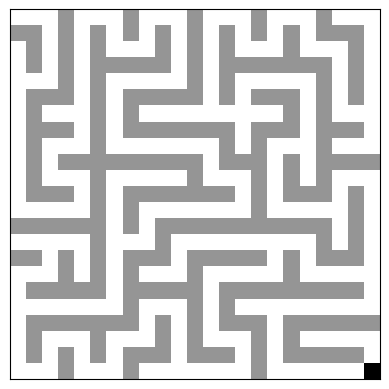

In [3]:
# maze generator
def make_maze(width):
    maze = torch.zeros((width, width))
    def add_exit(maze):
        choices = (maze == 1).nonzero().tolist()
        furthest = max(choices, key=lambda x: x[0] + x[1])
        maze[furthest[0], furthest[1]] = -1

    def rec(x, y):
        while True:
            pairs = []
            for move in MOVES:
                dx, dy = move
                nx, ny = x + dx, y + dy
                nnx, nny = nx + dx, ny + dy
                if 0 <= nnx < width and 0 <= nny < width and maze[nnx, nny] == 0 and maze[nx, ny] == 0:
                    pairs.append((nx, ny, nnx, nny))
            random.shuffle(pairs)
            if not pairs: break
            nx, ny, nnx, nny = pairs[0]
            maze[nx, ny], maze[nnx, nny] = 1, 1
            rec(nnx, nny)

    maze[0, 0] = 1
    rec(0, 0)
    add_exit(maze)
    return maze

def ascii_maze(maze):
    lookup = {0: '@', 1: '_', -1: 'x'}
    print('\n'.join(''.join(lookup[i] for i in row) for row in maze.tolist()))

def plot_maze(maze, ax=None, figsize=None):
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    ax.imshow(-maze, 'Greys')
    ax.set_xticks([])
    ax.set_yticks([])

# look at the maze
maze = make_maze(23)
plot_maze(maze)
# ascii_maze(maze)

In [4]:
# maze generator
def make_maze_steps(width):
    maze = torch.zeros((width, width))
    steps = []

    def rec(x, y):
        while True:
            pairs = []
            for move in MOVES:
                dx, dy = move
                nx, ny = x + dx, y + dy
                nnx, nny = nx + dx, ny + dy
                if 0 <= nnx < width and 0 <= nny < width and maze[nnx, nny] == 0 and maze[nx, ny] == 0:
                    pairs.append((nx, ny, nnx, nny))
            random.shuffle(pairs)
            if not pairs: break
            nx, ny, nnx, nny = pairs[0]
            maze[nx, ny], maze[nnx, nny] = 2, 2
            cp = copy.deepcopy(maze)
            cp[nx, ny], cp[nnx, nny] = 1, 1
            steps.append(cp)
            steps.append(copy.deepcopy(maze))
            rec(nnx, nny)

    maze[0, 0] = 2
    rec(0, 0)
    return steps

In [5]:
def get_frame(steps, ax):
    def f(d):
        ax.clear()
        ax.set_title(f'step {d // 2}')
        plot_maze(steps[d], ax=ax)
    return f

steps = make_maze_steps(23)
fig, ax = plt.subplots(figsize=(3, 3))
ani = FuncAnimation(fig, get_frame(steps, ax), frames=len(steps), interval=50, repeat=False)
plt.close()

display(HTML(ani.to_jshtml())) # display inline
ani.save('maze-creation.gif', fps=20) # save to disk

### distances to exit

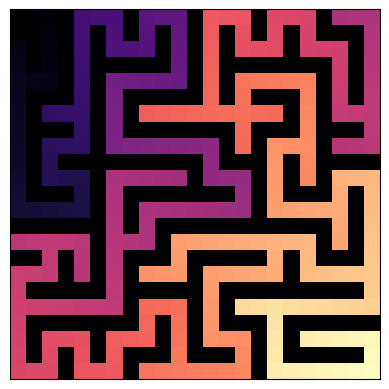

In [6]:
# compute optimal distances to the exit
def dists(maze):
    MAZE_WIDTH = maze.shape[0]
    pos = tuple((maze == -1).nonzero().tolist()[0]) # locate the exit
    dist = torch.zeros_like(maze)
    seen = set()
    q = deque()
    q.append((pos, 0))
    while q:
        pos, d = q.popleft()
        if pos in seen: continue
        if maze[pos] == 0: continue
        seen.add(pos)
        dist[pos] = d
        for move in MOVES:
            new_pos = (pos[0] + move[0], pos[1] + move[1])
            if 0 <= new_pos[0] < MAZE_WIDTH and 0 <= new_pos[1] < MAZE_WIDTH:
                q.append((new_pos, d + 1))
    return dist

def formatted_dists(maze):
    dist = dists(maze)
    unreachable = (dist == 0) & (maze == 1)
    # revert distances for plotting
    mask = maze != 0
    dist[mask] = dist.max() - dist[mask]
    # hide unreachable
    dist[unreachable] = torch.nan
    return dist

def plot_dists(maze, ax=None, figsize=None):
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    dist = formatted_dists(maze)
    ax.imshow(dist, cmap=plt.cm.magma, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])

plot_dists(maze)

In [7]:
def get_frame(maze, ds, ax):
    def f(step):
        mz = copy.deepcopy(ds)
        mz[ds > step] = 0.
        mask = maze != 0
        mz[mask] = ds.max() - mz[mask]
        ax.clear()
        ax.set_title(f'step {step}')
        ax.imshow(mz, cmap=plt.cm.magma, interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])
    return f

def animate_dists(maze, figsize=(3, 3)):
    ds = dists(maze)
    fig, ax = plt.subplots(figsize=figsize)
    ani = FuncAnimation(fig, get_frame(maze, ds, ax), frames=int(ds.max().item()) + 1, interval=50, repeat=False)
    plt.close()
    return ani

ani = animate_dists(maze)
display(HTML(ani.to_jshtml())) # display inline
ani.save('maze-dists.gif', fps=20) # save to disk

### plot

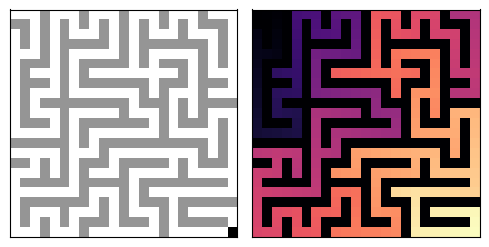

In [8]:
# plot maze and distances side by side
def plotm(maze, figsize=(5, 5)):
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    plot_maze(maze, ax=ax[0])
    plot_dists(maze, ax=ax[1])
    fig.tight_layout()

plotm(maze)

In [9]:
def plot(*args, n_col=None, figsize=None, block_size=3, dist=False):
    '''Plot the mazes in a grid
    usage: plot(maze1, maze2, ...)
    optional: n_col=3, figsize=(12, 8), block_size=1, dist=False

    maze: torch.Tensor of shape (H, W)
    '''
    mazes = []
    for maze in args:
        if isinstance(maze, torch.Tensor):
            if maze.dim() == 4: mazes.extend([maze[i] for i in range(maze.shape[0])])
            else: mazes.append(maze)

    # flatten channels
    mazes = [maze.squeeze(0) if maze.dim() == 3 else maze for maze in mazes]
    mazes = [maze.detach().cpu() for maze in mazes]

    if n_col is None: n_col = len(mazes)
    n_row = math.ceil(len(mazes) / n_col)
    if figsize is None: figsize = (n_col * block_size, n_row * block_size)
    if dist: mazes = [formatted_dists(m) for m in mazes]
    # normalize ax to 2d array
    fig, ax = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row == 1 and n_col == 1: ax = np.array([[ax]])
    elif n_row == 1: ax = ax.reshape((1, -1))
    elif n_col == 1: ax = ax.reshape((-1, 1))
    # plot
    for i, maze in enumerate(mazes):
        idx = (i // n_col, i % n_col)
        if dist: ax[idx].imshow(maze, cmap=plt.cm.magma, interpolation='nearest')
        else: ax[idx].imshow(-maze, 'Greys')
    # remove the axis
    for i in range(n_row * n_col):
        idx = (i // n_col, i % n_col)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        if i >= len(mazes): ax[idx].axis('off')
    plt.tight_layout()
    plt.show()

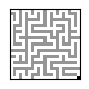

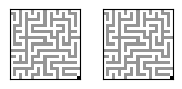

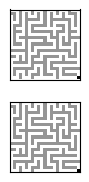

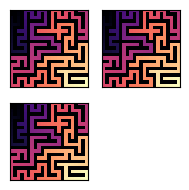

In [10]:
# test plot function
plot(maze, block_size=1)
plot(maze, maze, block_size=1)
plot(maze, maze, n_col=1, block_size=1)
plot(maze, maze, maze, n_col=2, block_size=1, dist=True)

## Autoencoder / VAE

### theory
- autoencoder: https://arxiv.org/pdf/2003.05991.pdf
- VAE: https://arxiv.org/pdf/1312.6114.pdf
- Cyclical Annealing: https://arxiv.org/pdf/1903.10145.pdf
- VQ-VAE: https://arxiv.org/pdf/1711.00937.pdf
- NVAE: https://arxiv.org/pdf/2007.03898.pdf

## data

In [11]:
data = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True),
    batch_size=128,
    shuffle=True)

## visualizations

In [12]:
@torch.no_grad()
def plot_sample(model, range_=(-3, 4), block_size=0.5, hook=lambda x: x):
    imgs = []
    for i in range(*range_):
        for j in range(*range_):
            latent = torch.tensor([i, j]).unsqueeze(0).float().to(device)
            img = model.decoder(latent)
            imgs.append(hook(img))
    plot(*imgs, block_size=block_size, n_col=range_[1]-range_[0])

In [13]:
@torch.no_grad()
def plot_latent(model, data, num_batches=100, is_variational=True):
    for i, (x, y) in enumerate(data):
        z = model.encoder(x.to(device))
        if is_variational:
            z = model.sample(z)
        z = z.detach().cpu()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

## Autoencoder

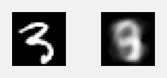

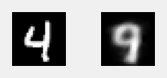

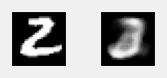

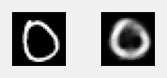

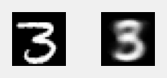

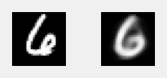

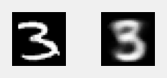

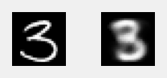

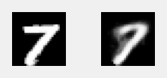

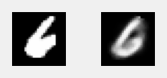

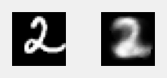

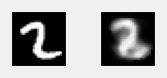

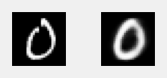

In [152]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims=2, input_dims=28, hidden_dims=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(input_dims**2, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, latent_dims)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, input_dims**2),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, input_dims, input_dims)),
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

def train(model, data, epochs=20, lr=3e-4, log_every=3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for x, _label in data:
            x = x.to(device)
            x_hat = model(x)
            loss = ((x - x_hat)**2).sum()
            opt.zero_grad()
            loss.backward()
            opt.step()
        # visualize progress
        if epoch % log_every == log_every - 1:
            with torch.no_grad():
                img = data.__iter__().__next__()[0][0, :, :, :].to(device)
                res = model(img)
                plot(img, res, block_size=1)

a = Autoencoder(latent_dims=2).to(device)
train(a, data, epochs=40)

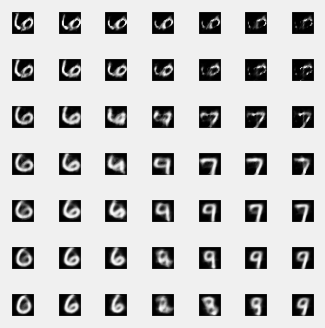

In [319]:
plot_sample(a)

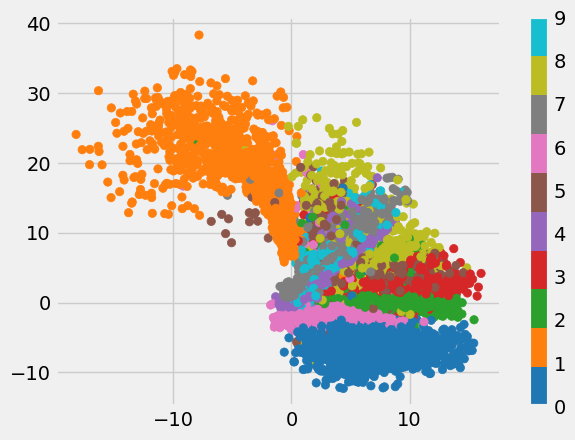

In [158]:
plot_latent(a, data, is_variational=False)

## VAE

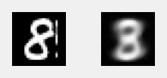

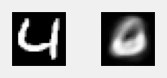

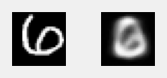

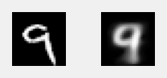

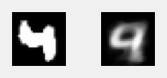

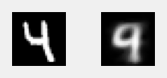

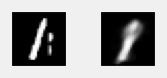

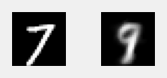

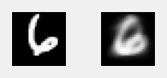

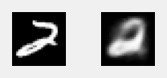

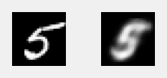

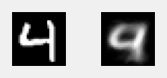

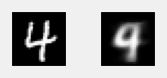

In [159]:
class VAE(nn.Module):
    '''Variational autoencoder'''
    def __init__(self, latent_dims=2, input_dims=28, hidden_dims=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(input_dims**2, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, 2 * latent_dims)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, input_dims**2),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, input_dims, input_dims)),
        )
        self.kl = 0

    def sample(self, x):
        mu, log_var = x.chunk(2, dim=1)
        sigma = torch.exp(log_var)
        z = mu + sigma * torch.randn_like(sigma)
        self.kl = 0.5 * (sigma**2 + mu**2 - torch.log(sigma) - 1).sum()
        return z

    def forward(self, x):
        x = self.encoder(x)
        z = self.sample(x)
        return self.decoder(z)

def train(model, data, epochs=20, lr=3e-4, log_every=3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for x, _label in data:
            x = x.to(device)
            x_hat = model(x)
            loss = ((x - x_hat)**2).sum() + model.kl
            opt.zero_grad()
            loss.backward()
            opt.step()
        # visualize progress
        if epoch % log_every == log_every - 1:
            with torch.no_grad():
                img = data.__iter__().__next__()[0][0, :, :, :].to(device)
                res = model(img)
                plot(img, res, block_size=1)

vae = VAE(latent_dims=2).to(device)
train(vae, data, epochs=40)

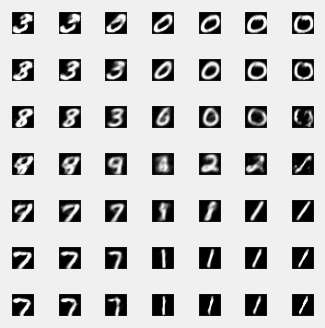

In [160]:
plot_sample(v)

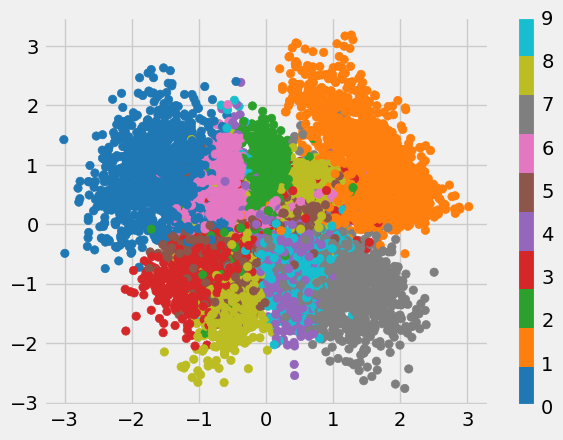

In [161]:
plot_latent(v, data)

## VAE annealing

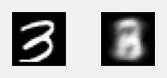

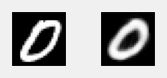

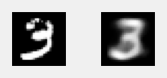

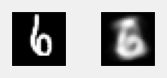

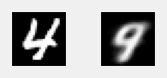

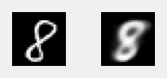

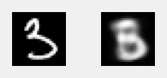

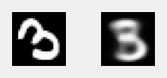

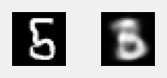

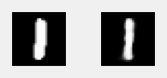

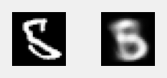

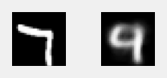

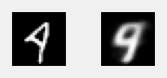

In [162]:
def annealing_train(model, data, epochs=20, lr=3e-4, log_every=3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        annealing = min(epoch, epochs // 2) / (epochs // 2)
        for x, _label in data:
            x = x.to(device)
            x_hat = model(x)
            loss = ((x - x_hat)**2).sum() + model.kl * annealing
            opt.zero_grad()
            loss.backward()
            opt.step()
        # visualize progress
        if epoch % log_every == log_every - 1:
            with torch.no_grad():
                img = data.__iter__().__next__()[0][0, :, :, :].to(device)
                res = model(img)
                plot(img, res, block_size=1)

va = VAE(latent_dims=2).to(device)
annealing_train(va, data, epochs=40)

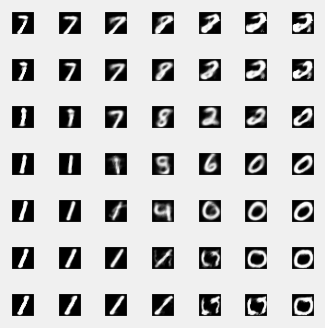

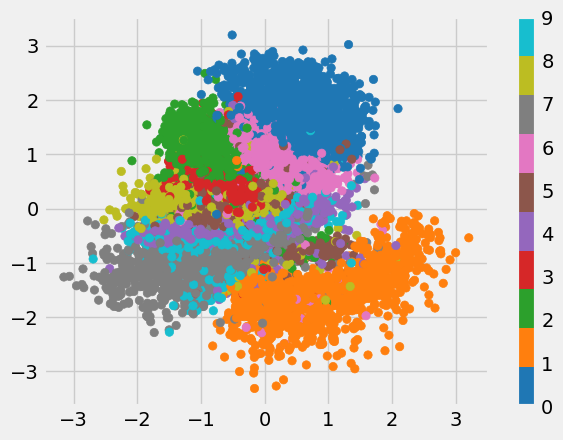

In [163]:
plot_sample(va)
plot_latent(va, data)

## VAE cyclic annealing

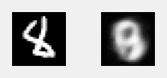

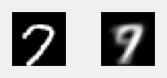

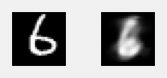

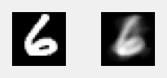

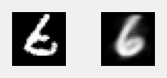

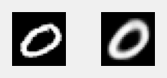

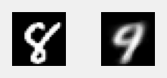

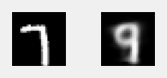

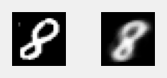

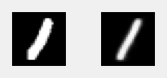

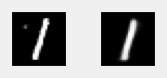

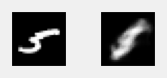

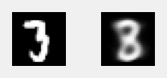

In [164]:
def cyclic_annealing_train(model, data, epochs=20, lr=3e-4, log=True, log_every=3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    n_batch = len(data.__iter__())
    for epoch in range(epochs):
        for i, (x, _label) in enumerate(data):
            annealing = min(i, n_batch // 2) / (n_batch // 2)
            x = x.to(device)
            x_hat = model(x)
            loss = ((x - x_hat)**2).sum() + model.kl * annealing
            opt.zero_grad()
            loss.backward()
            opt.step()
        # visualize progress
        if log and epoch % log_every == log_every - 1:
            with torch.no_grad():
                img = data.__iter__().__next__()[0][0, :, :, :].to(device)
                res = model(img)
                plot(img, res, block_size=1)

vca = VAE(latent_dims=2).to(device)
cyclic_annealing_train(vca, data, epochs=40)

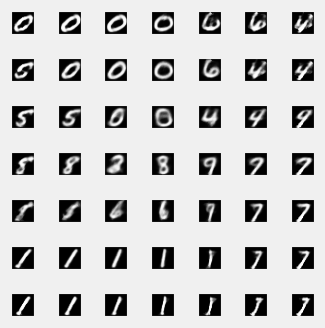

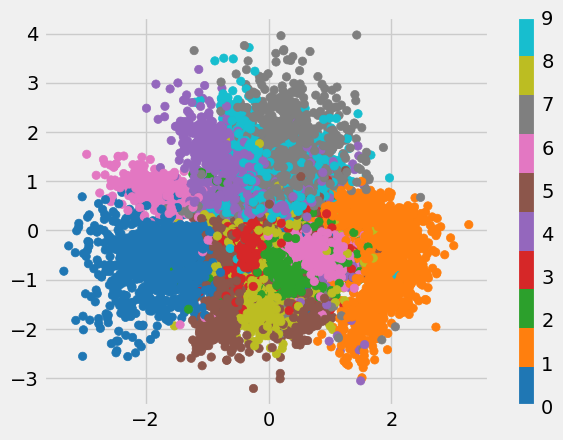

In [165]:
plot_sample(vca)
plot_latent(vca, data)

## for mazes

In [166]:
dataset_size = 1280
many_mazes = torch.stack([make_maze(28).unsqueeze(0) for _ in range(dataset_size)])
labels = torch.zeros_like(many_mazes)
maze_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(many_mazes, labels),
    batch_size=128,
    shuffle=True)

In [167]:
maze_data.__iter__().__next__()[0].shape

torch.Size([128, 1, 28, 28])

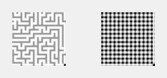

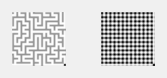

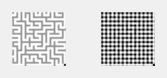

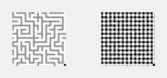

In [168]:
vca_maze = VAE(latent_dims=2).to(device)
cyclic_annealing_train(vca_maze, maze_data, epochs=2000, log_every=500)

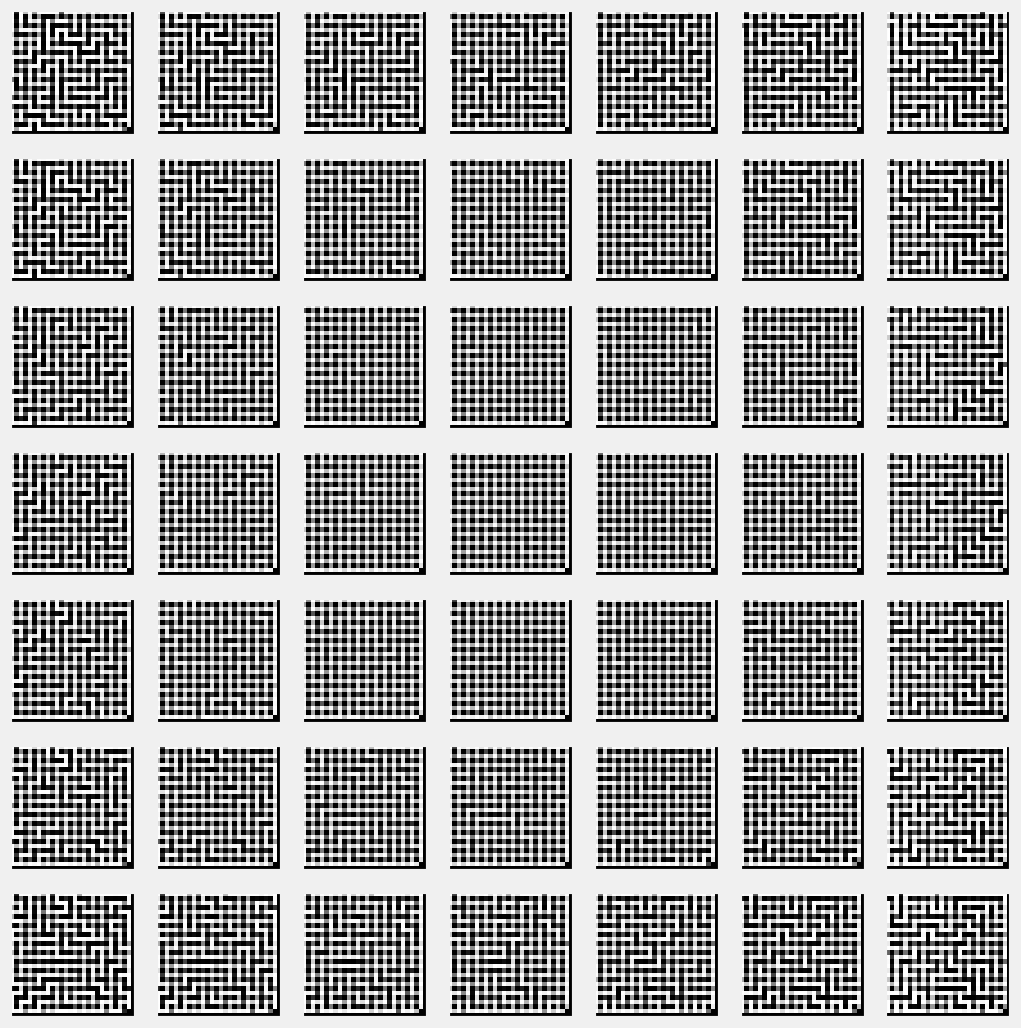

In [320]:
# plot the fuzzy samples of mazes from the latent space
plot_sample(vca_maze, block_size=1.5)

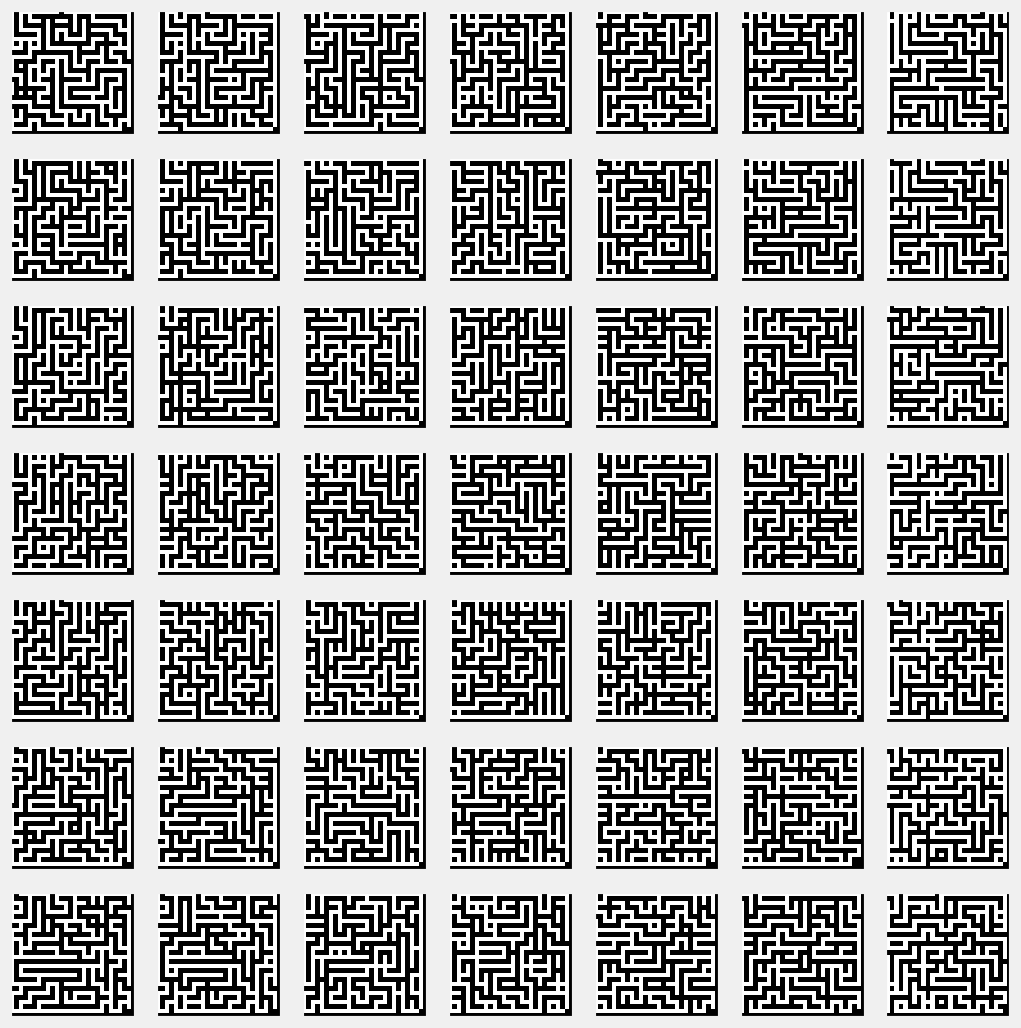

In [321]:
# plot the samples of mazes from the latent space with a threshold
plot_sample(vca_maze, block_size=1.5, hook=lambda x: (x > 0.5).float())

## GAN

### theory
https://arxiv.org/pdf/1406.2661.pdf

$\min_{G} \max_{D} V(D, G) = \mathbb{E}_{x\sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z\sim p_z(z)}[\log(1 - D(G(z)))].$

### hyperparams

In [12]:
LEARNING_RATE = 3e-4
EPOCHS = 50
# EPOCHS = 2000
BATCH_SIZE = 128
IMG_DIMS = 28
NOISE_DIMS = 10
HIDDEN_DIMS = 512

### data

In [13]:
data = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True),
    batch_size=BATCH_SIZE,
    shuffle=True)

In [16]:
data.__iter__().__next__()[0].shape

torch.Size([128, 1, 28, 28])

### generator

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(NOISE_DIMS, HIDDEN_DIMS),
            nn.BatchNorm1d(HIDDEN_DIMS),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIMS, HIDDEN_DIMS),
            nn.BatchNorm1d(HIDDEN_DIMS),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIMS, HIDDEN_DIMS),
            nn.BatchNorm1d(HIDDEN_DIMS),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIMS, IMG_DIMS**2),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, IMG_DIMS, IMG_DIMS))
        )

    def forward(self, noise):
        return self.layers(noise)

### discriminator

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(IMG_DIMS**2, HIDDEN_DIMS),
            nn.LeakyReLU(0.2),  # supposed to help with mode collapse
            nn.Linear(HIDDEN_DIMS, HIDDEN_DIMS),
            nn.LeakyReLU(0.2),
            nn.Linear(HIDDEN_DIMS, 1),
            nn.Sigmoid()
        )

    def forward(self, image):
        return self.layers(image)

### train: Base

In [18]:
def train_gan(discriminator, generator, data=data, epochs=EPOCHS, lr=LEARNING_RATE, log_every=10):
    losses_d, losses_g = [], []
    samples = []
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr)
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr)

    for epoch in range(epochs):
        for minibatch, _ in data:
            batch_size = minibatch.size(0)
            minibatch = minibatch.to(device)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            noise = torch.randn(batch_size, NOISE_DIMS, device=device)
            fake_images = generator(noise)

            # discriminator
            outputs_real = discriminator(minibatch)
            loss_real = F.binary_cross_entropy(outputs_real, real_labels)
            outputs_fake = discriminator(fake_images.detach())
            loss_fake = F.binary_cross_entropy(outputs_fake, fake_labels)
            loss_d = loss_real + loss_fake
            discriminator.zero_grad()
            loss_d.backward()
            opt_d.step()

            # generator
            outputs = discriminator(fake_images)
            loss_g = F.binary_cross_entropy(outputs, real_labels)
            generator.zero_grad()
            loss_g.backward()
            opt_g.step()

            # logging
            losses_d.append(loss_d.item())
            losses_g.append(loss_g.item())

        samples.append(fake_images[1,:,:,:])
        if epoch % log_every == log_every - 1:
            plot(*samples[-9:])
            samples = []

    plt.plot(losses_g, label='generator')
    plt.plot(losses_d, label='discriminator')
    plt.legend()

In [26]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
train_gan(discriminator, generator)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### exploitation

In [32]:
def gen_images(model, n=9):
    noise = torch.randn(n, NOISE_DIMS, device=device)
    fake_images = model(noise)
    return fake_images

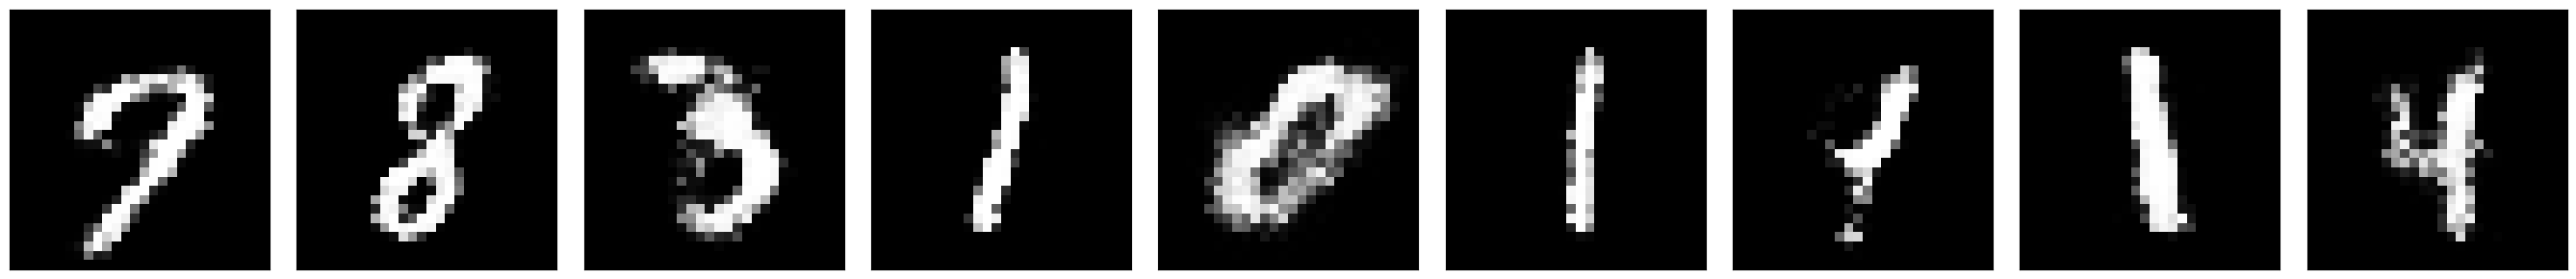

In [ ]:
imgs = gen_images(generator, n=9)
plot(imgs)

### save

In [ ]:
# torch.save(discriminator.state_dict(), 'discriminator.pt')
# torch.save(generator.state_dict(), 'generator.pt')

### for mazes

In [ ]:
dataset_size = 1280
many_mazes = torch.stack([make_maze(28).unsqueeze(0) for _ in range(dataset_size)])
labels = torch.zeros_like(many_mazes)
maze_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(many_mazes, labels),
    batch_size=128,
    shuffle=True)

In [ ]:
maze_discriminator = Discriminator().to(device)
maze_generator = Generator().to(device)
train_gan(maze_discriminator, maze_generator, data=maze_data, epochs=100, log_every=100)

In [ ]:
imgs = gen_images(maze_generator, n=9)
plot(imgs)
plot((imgs > 0.5).float())

### improve training

#### train: Instance Noise

In [23]:
def train_gan_instance_noise(discriminator, generator, noise_std=0.1, data=data, epochs=EPOCHS, lr=LEARNING_RATE, log_every=10):
    def noisify(images):
        return images + torch.randn_like(images).to(device) * noise_std

    losses_d, losses_g = [], []
    samples = []
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr)
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr)

    for epoch in range(epochs):
        for minibatch, _ in data:
            batch_size = minibatch.size(0)
            minibatch = minibatch.to(device)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            noise = torch.randn(batch_size, NOISE_DIMS, device=device)
            fake_images = generator(noise)

            # discriminator
            outputs_real = discriminator(noisify(minibatch))
            loss_real = F.binary_cross_entropy(outputs_real, real_labels)
            outputs_fake = discriminator(noisify(fake_images.detach()))
            loss_fake = F.binary_cross_entropy(outputs_fake, fake_labels)
            loss_d = loss_real + loss_fake
            discriminator.zero_grad()
            loss_d.backward()
            opt_d.step()

            # generator
            outputs = discriminator(fake_images)
            loss_g = F.binary_cross_entropy(outputs, real_labels)
            generator.zero_grad()
            loss_g.backward()
            opt_g.step()

            # logging
            losses_d.append(loss_d.item())
            losses_g.append(loss_g.item())

        samples.append(fake_images[1,:,:,:])
        if epoch % log_every == log_every - 1:
            plot(*samples[-9:])
            samples = []

    plt.plot(losses_g, label='generator')
    plt.plot(losses_d, label='discriminator')
    plt.legend()

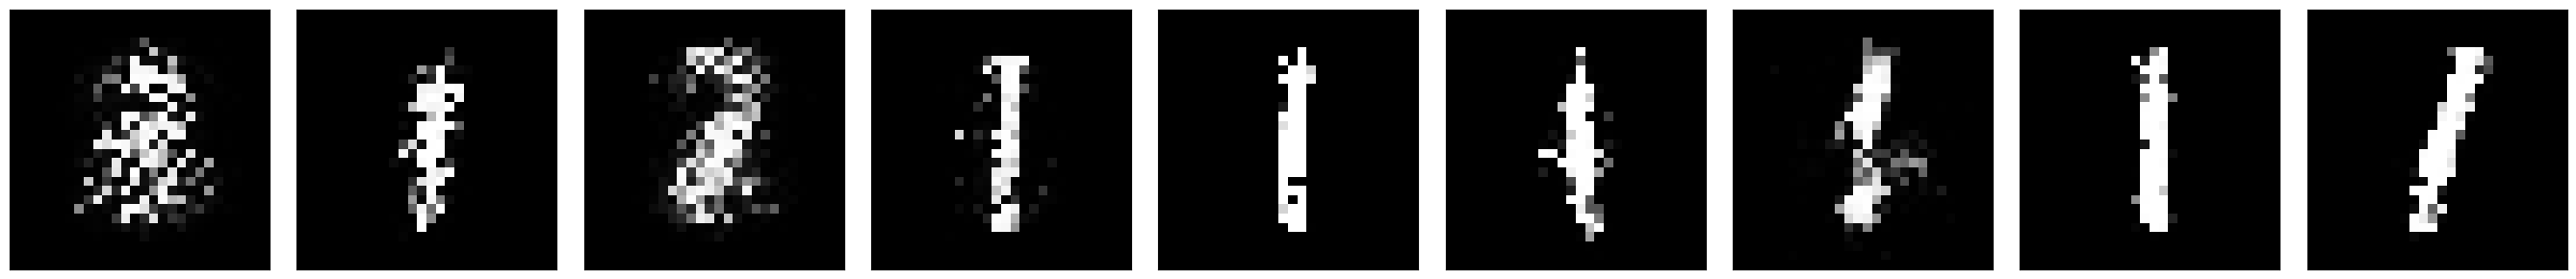

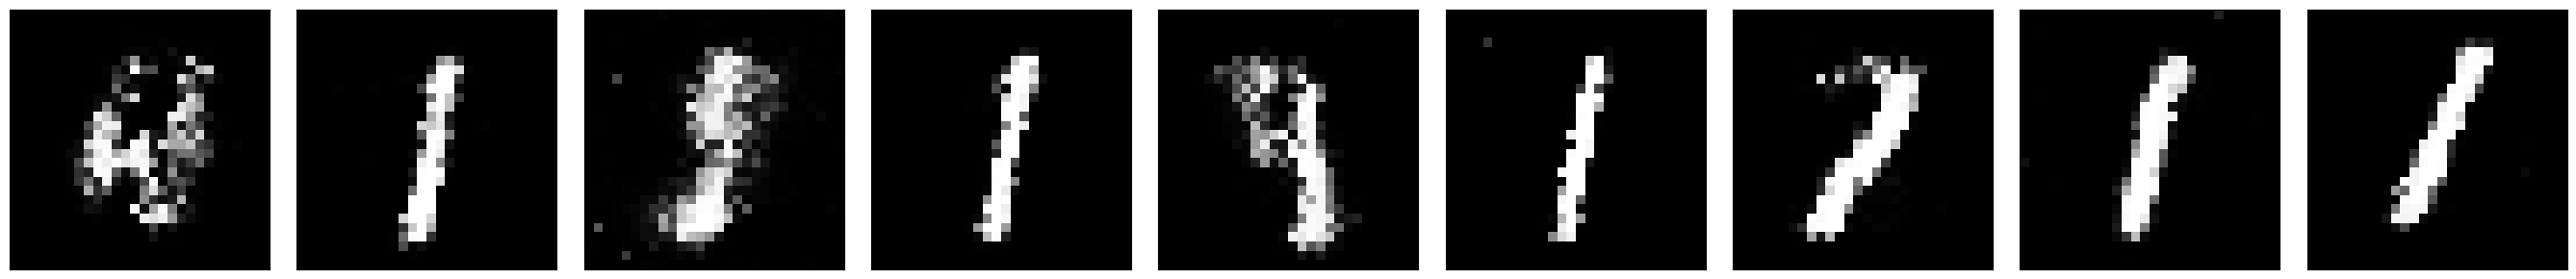

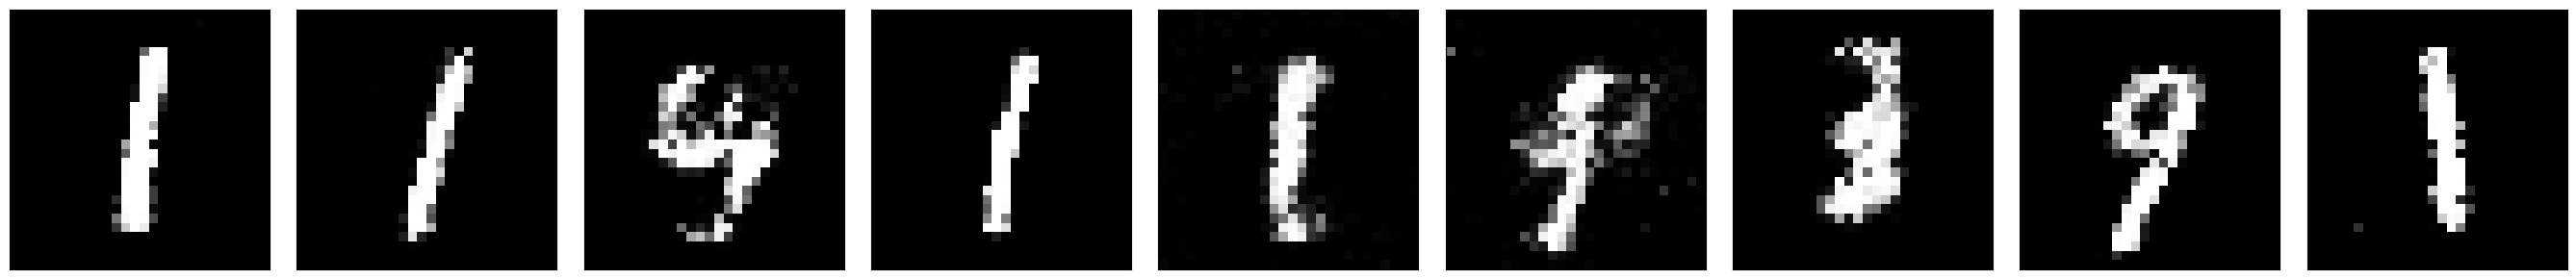

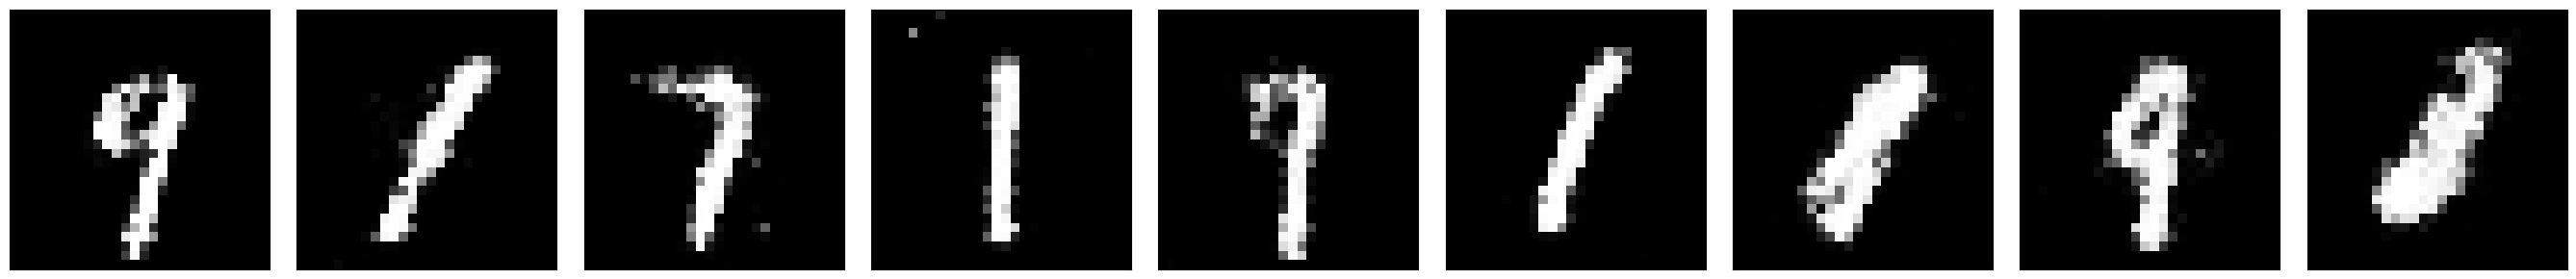

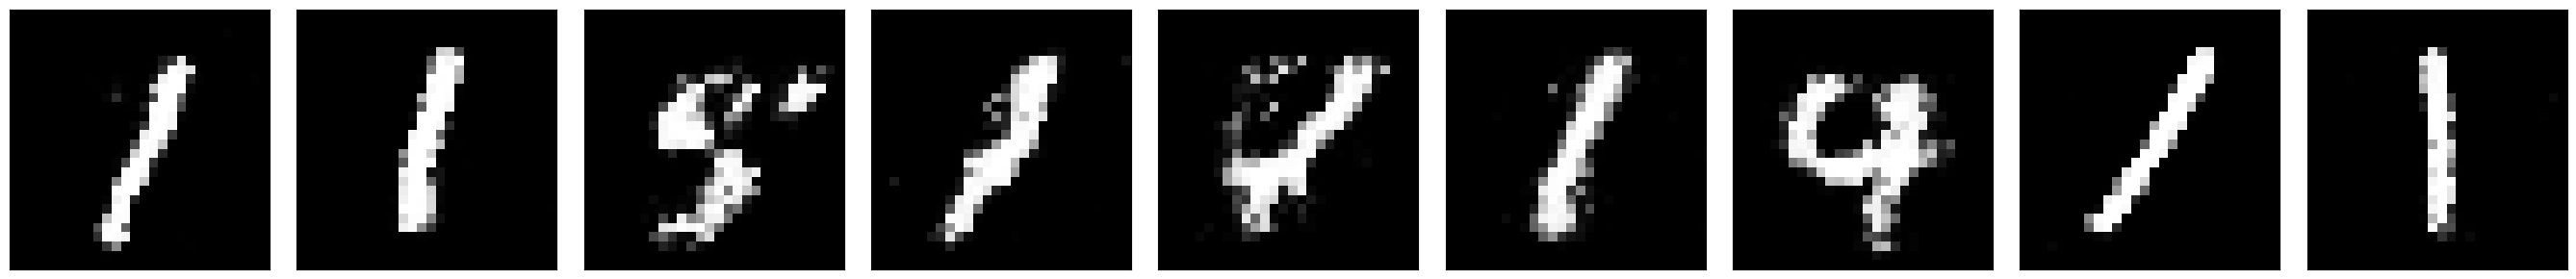

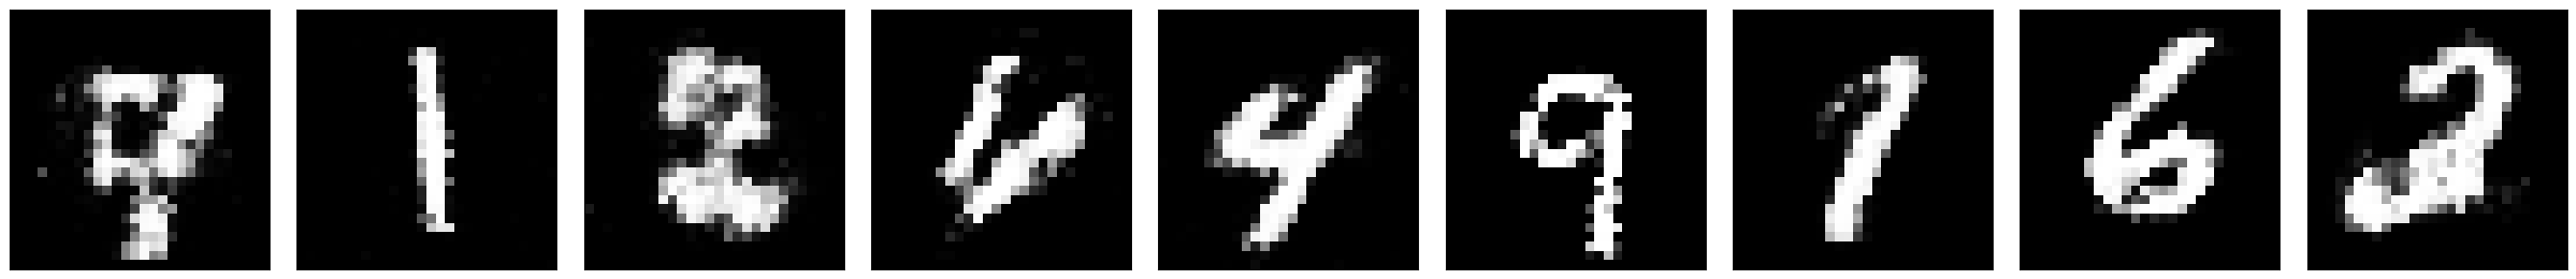

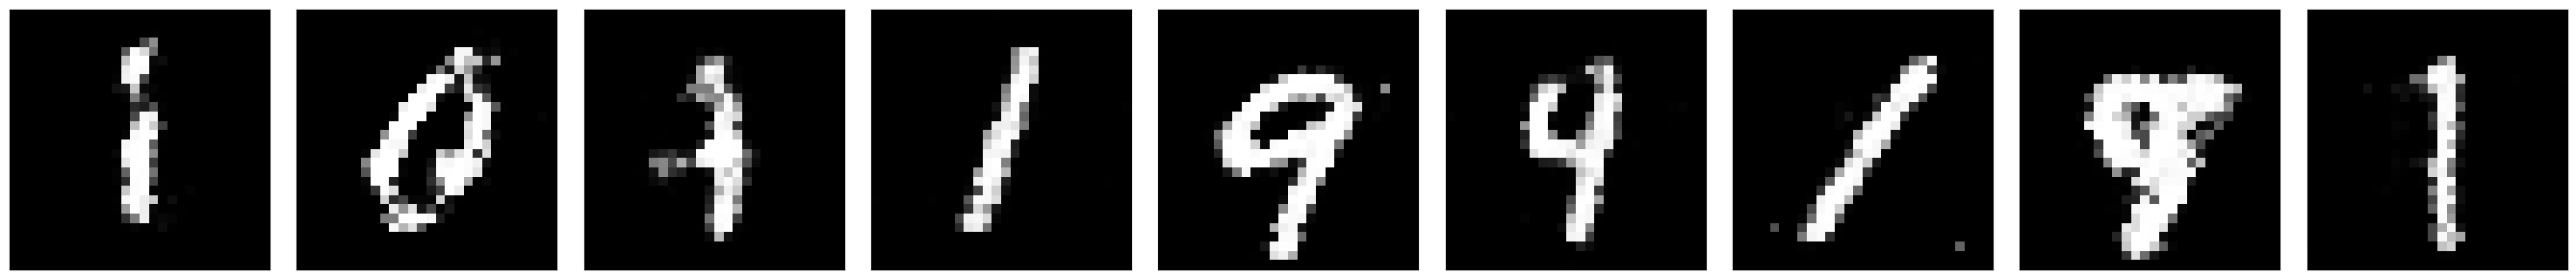

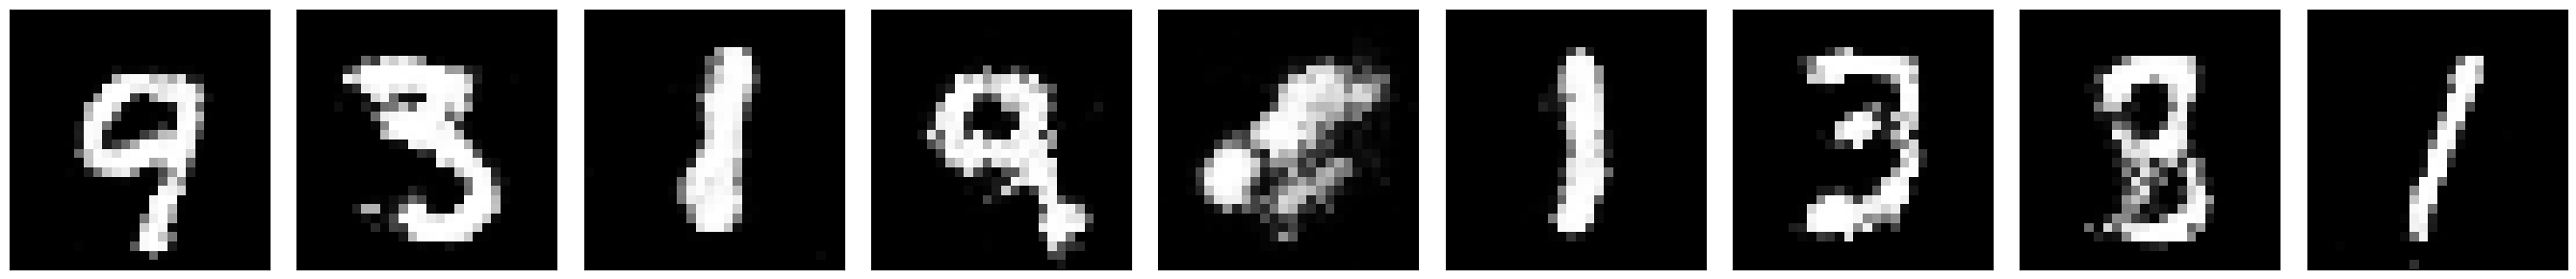

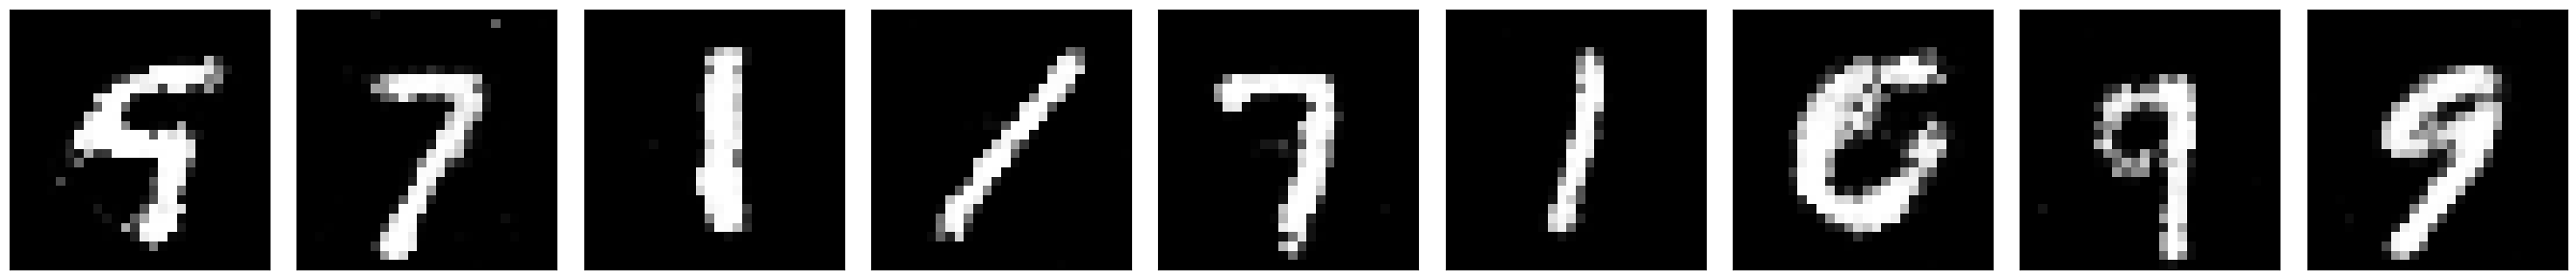

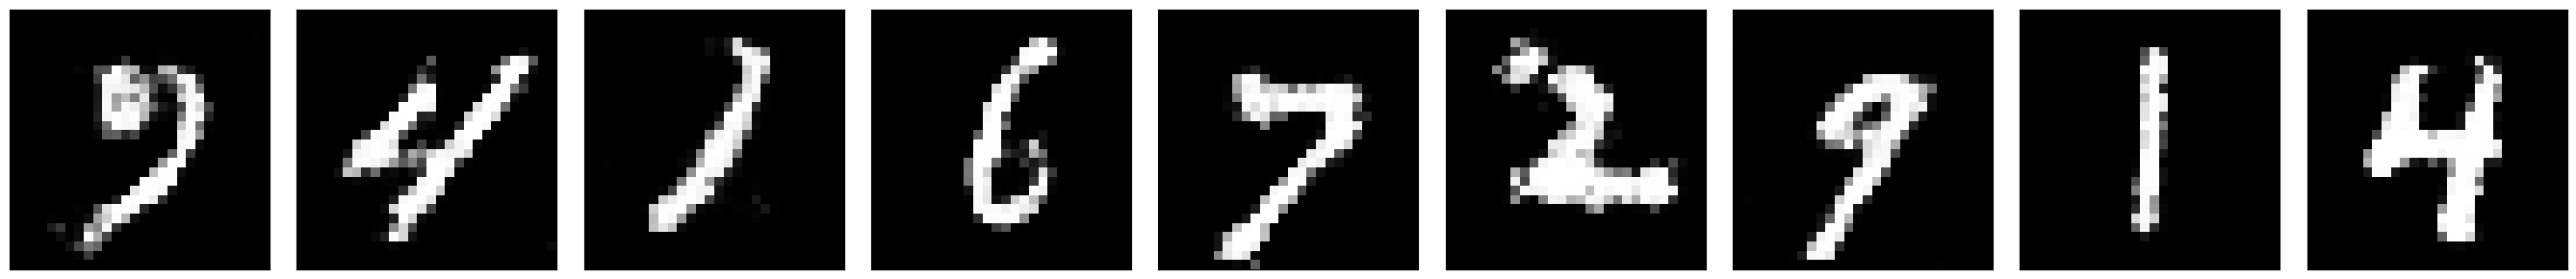

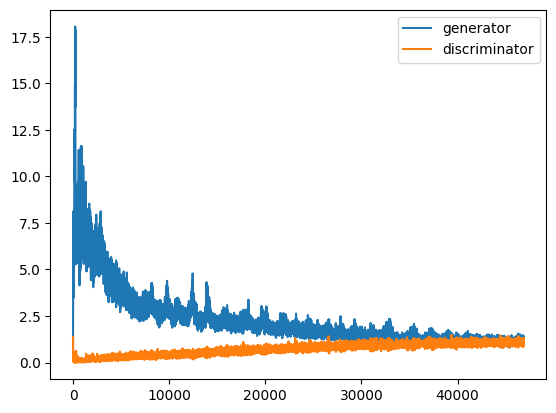

In [24]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
train_gan_instance_noise(discriminator, generator, data=data, epochs=100, log_every=10)

In [ ]:
imgs = gen_images(generator, n=9)
plot(imgs)

#### train: WGAN
Wasserstein GAN: https://arxiv.org/abs/1701.07875

In [54]:
def train_wgan(discriminator, generator, clip_threshold=0.01, extra_discriminator_training=5, data=data, epochs=EPOCHS, lr=LEARNING_RATE, log_every=10):
    losses_d, losses_g = [], []
    samples = []
    opt_d = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
    opt_g = torch.optim.RMSprop(generator.parameters(), lr=lr)

    for epoch in range(epochs):
        for minibatch, _ in data:
            batch_size = minibatch.size(0)
            minibatch = minibatch.to(device)
            noise = torch.randn(batch_size, NOISE_DIMS, device=device)
            fake_images = generator(noise)

            # discriminator
            for _ in range(extra_discriminator_training):
                outputs_real = discriminator(minibatch)
                outputs_fake = discriminator(fake_images.detach())
                loss_d = outputs_fake.mean() - outputs_real.mean()
                discriminator.zero_grad()
                loss_d.backward()
                opt_d.step()
                for p in discriminator.parameters():
                    p.data.clamp_(-clip_threshold, clip_threshold)

            # generator
            outputs = discriminator(fake_images)
            loss_g = -outputs.mean()
            generator.zero_grad()
            loss_g.backward()
            opt_g.step()

            # logging
            losses_d.append(loss_d.item())
            losses_g.append(loss_g.item())

        samples.append(fake_images[1,:,:,:])
        if epoch % log_every == log_every -1:
            plot(*samples[-9:])
            samples = []

    plt.plot(losses_g, label='generator')
    plt.plot(losses_d, label='discriminator')
    plt.legend()

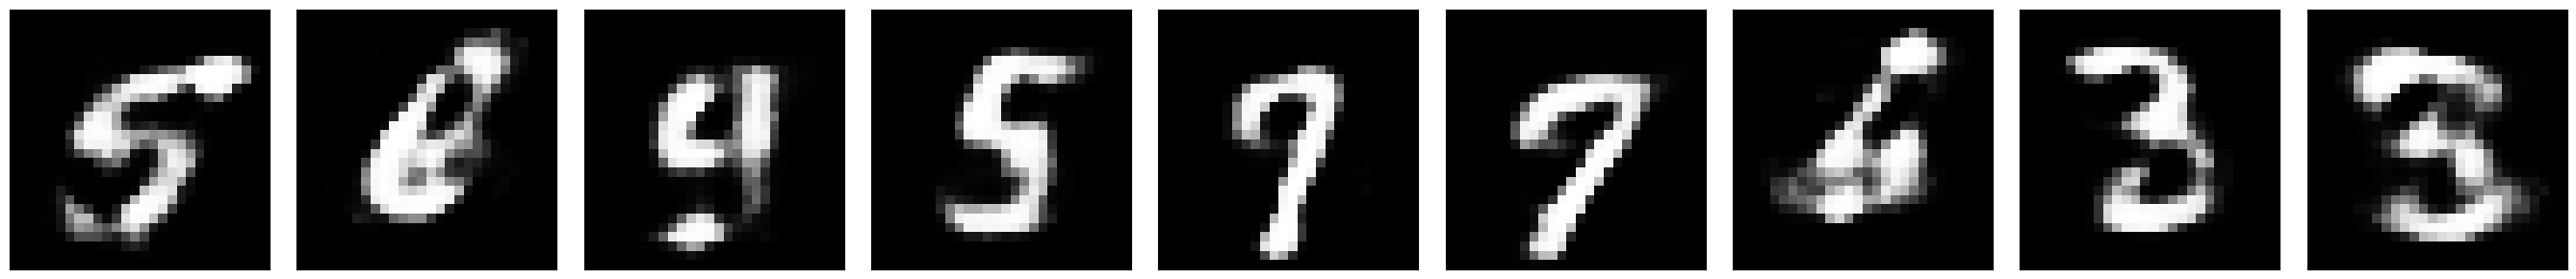

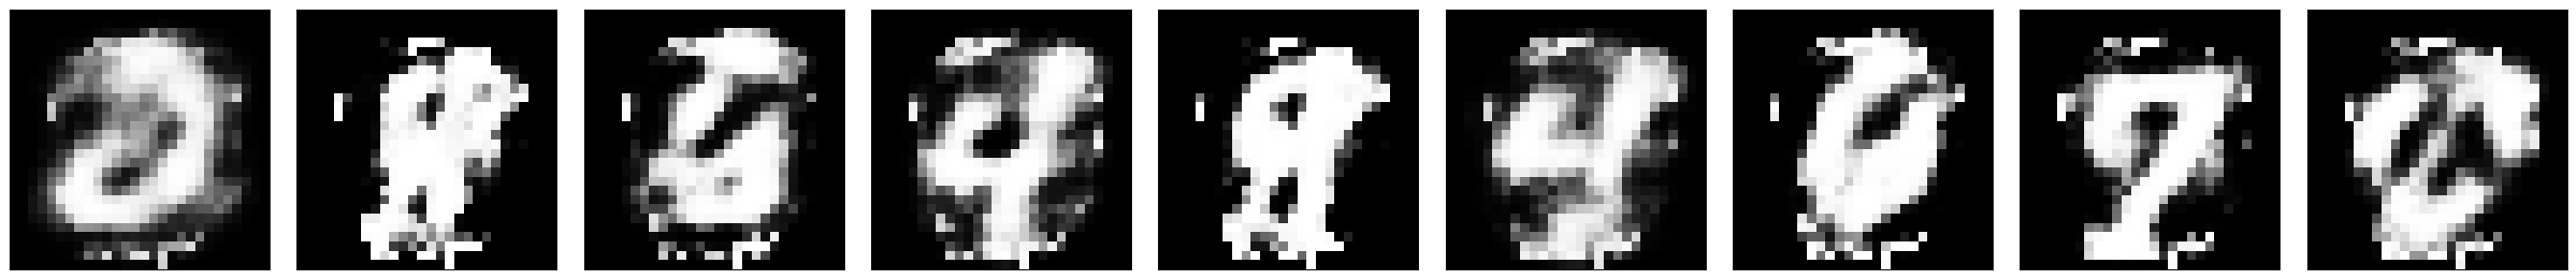

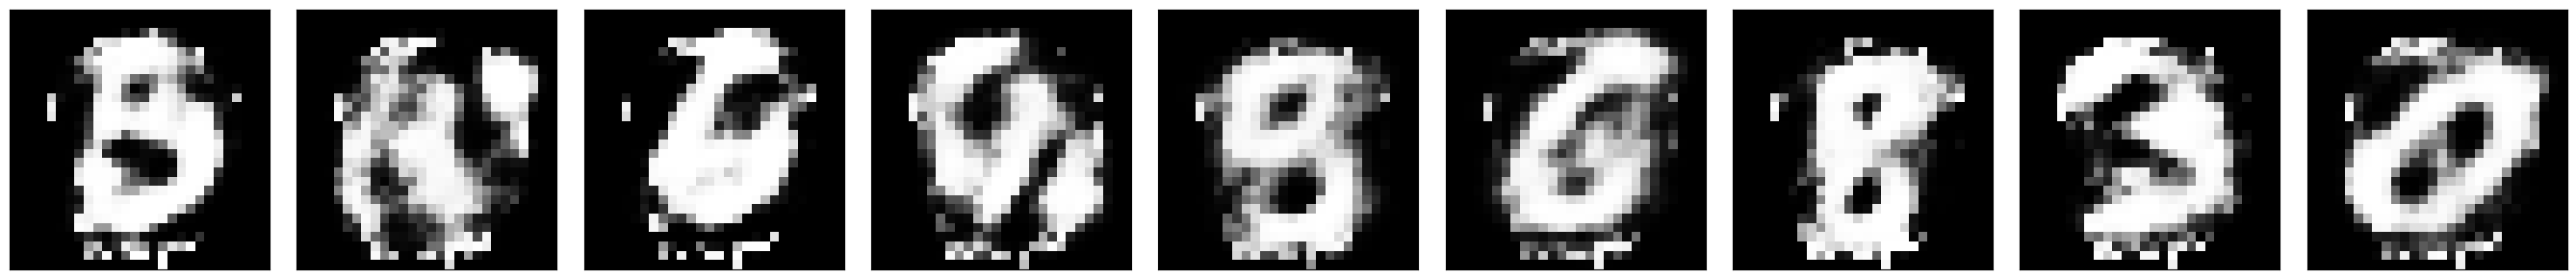

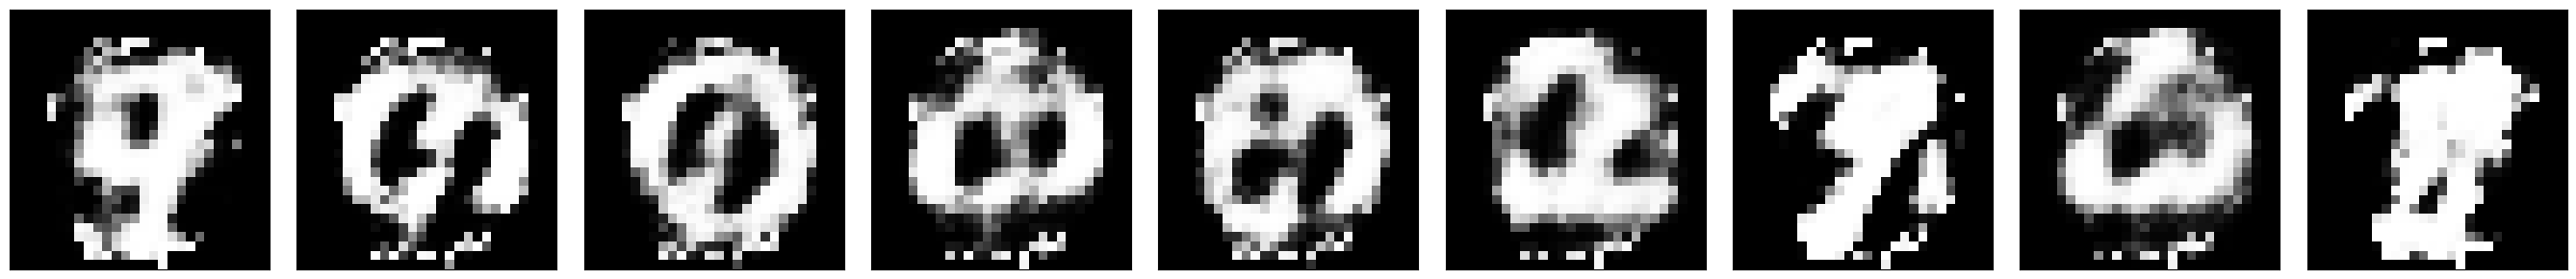

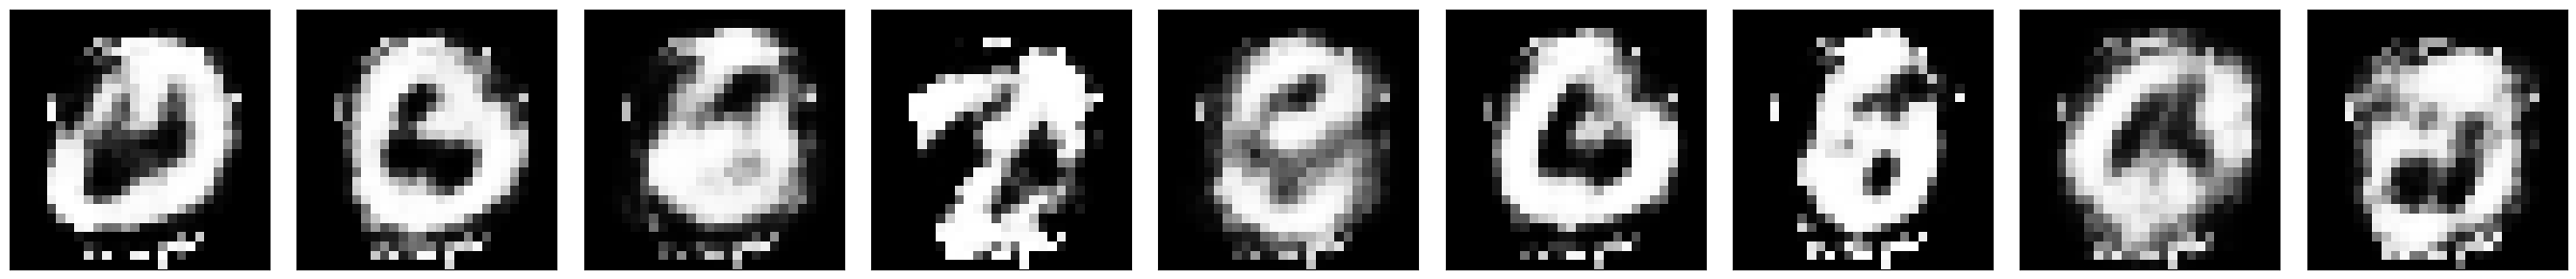

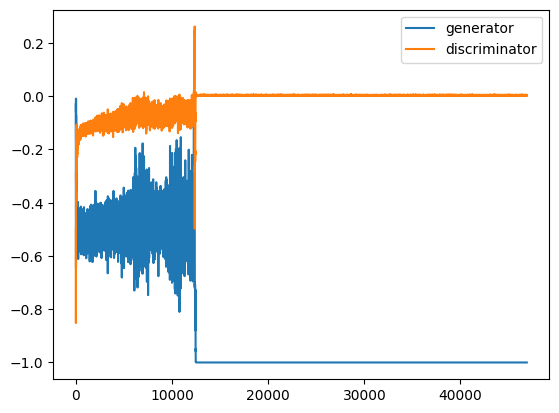

In [59]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
train_wgan(discriminator, generator, data=data, epochs=100, log_every=20)

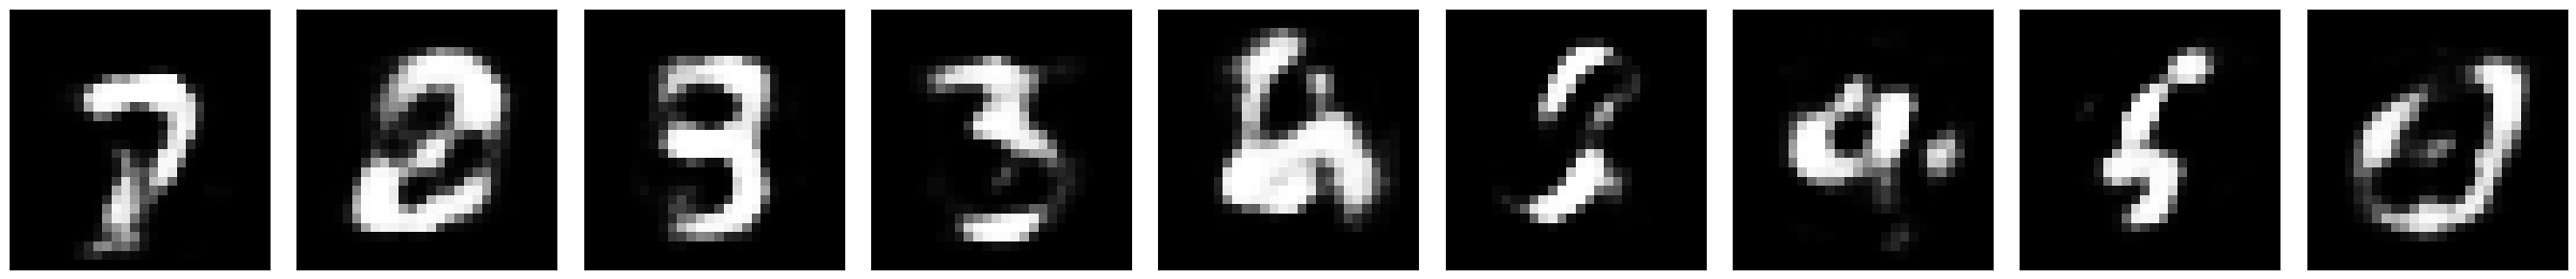

In [62]:
imgs = gen_images(generator, n=9)
plot(imgs)

#### train: WGAN + Noise

In [60]:
def train_wgan_noise(discriminator, generator, noise_std=0.01, clip_threshold=0.01, extra_discriminator_training=5, data=data, epochs=EPOCHS, lr=LEARNING_RATE, log_every=10):
    def noisify(images):
        return images + torch.randn_like(images).to(device) * noise_std
    
    losses_d, losses_g = [], []
    samples = []
    opt_d = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
    opt_g = torch.optim.RMSprop(generator.parameters(), lr=lr)

    for epoch in range(epochs):
        for minibatch, _ in data:
            batch_size = minibatch.size(0)
            minibatch = minibatch.to(device)
            noise = torch.randn(batch_size, NOISE_DIMS, device=device)
            fake_images = generator(noise)

            # discriminator
            for _ in range(extra_discriminator_training):
                outputs_real = discriminator(noisify(minibatch))
                outputs_fake = discriminator(noisify(fake_images.detach()))
                loss_d = outputs_fake.mean() - outputs_real.mean()
                discriminator.zero_grad()
                loss_d.backward()
                opt_d.step()
                for p in discriminator.parameters():
                    p.data.clamp_(-clip_threshold, clip_threshold)

            # generator
            outputs = discriminator(fake_images)
            loss_g = -outputs.mean()
            generator.zero_grad()
            loss_g.backward()
            opt_g.step()

            # logging
            losses_d.append(loss_d.item())
            losses_g.append(loss_g.item())

        samples.append(fake_images[1,:,:,:])
        if epoch % log_every == log_every -1:
            plot(*samples[-9:])
            samples = []

    plt.plot(losses_g, label='generator')
    plt.plot(losses_d, label='discriminator')
    plt.legend()

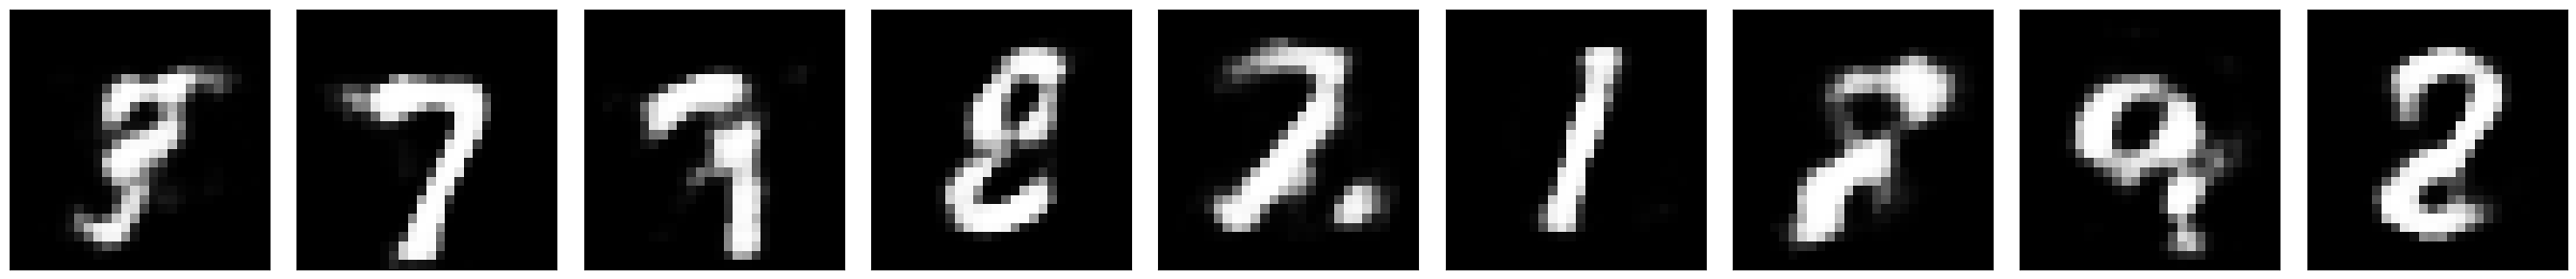

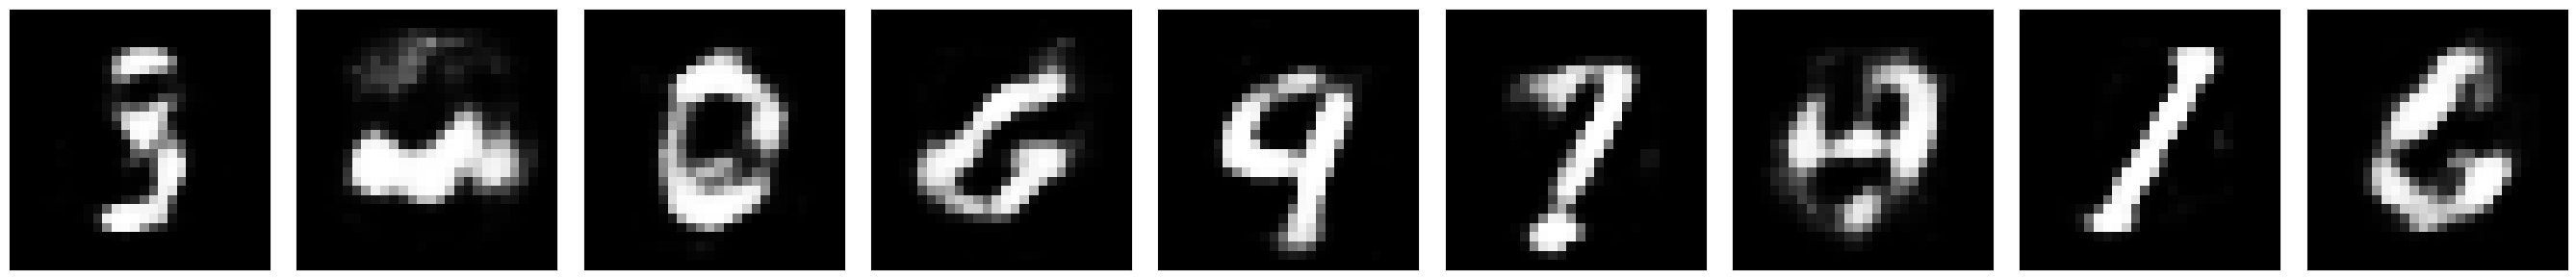

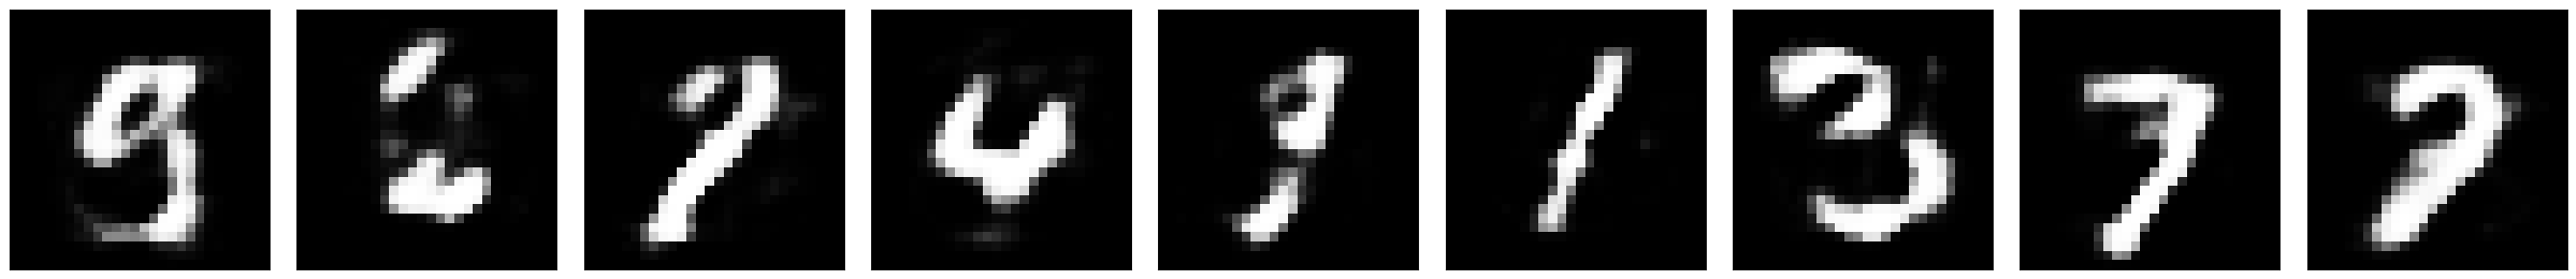

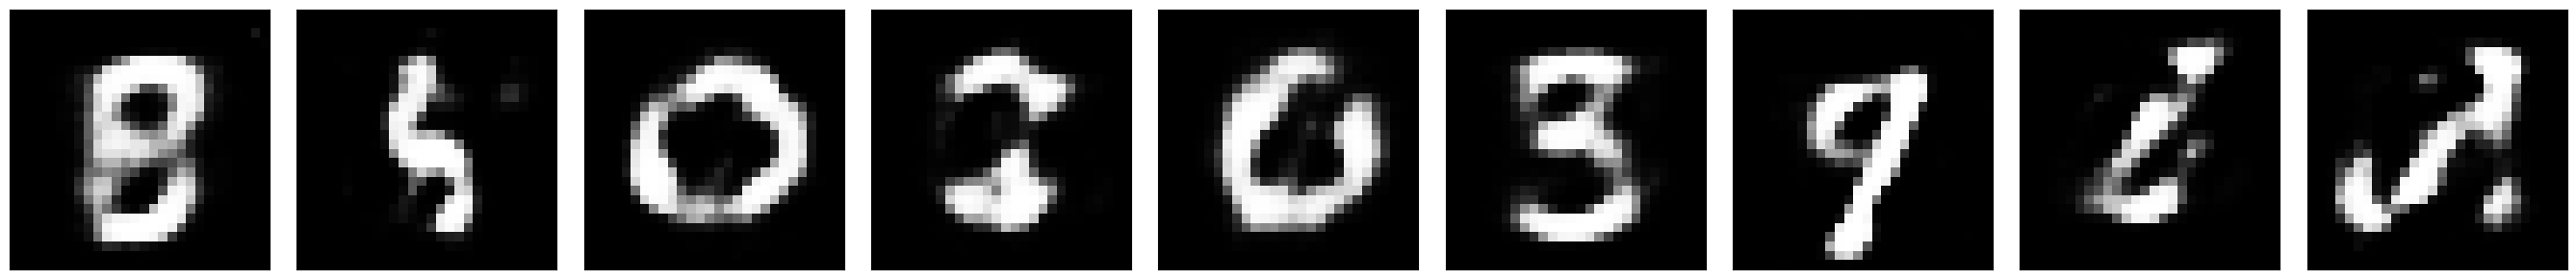

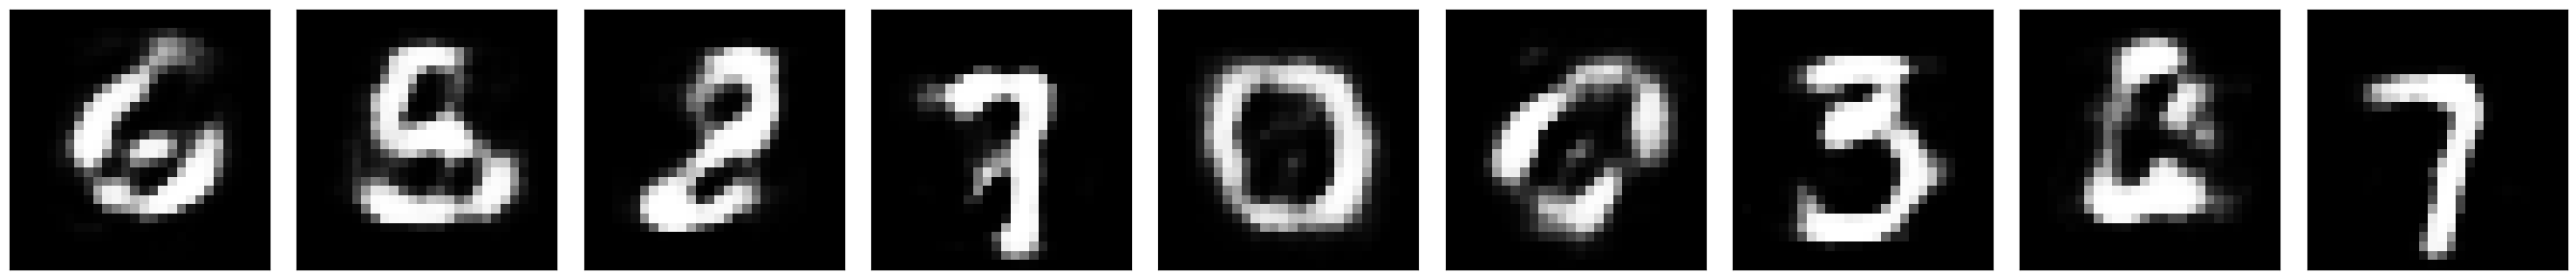

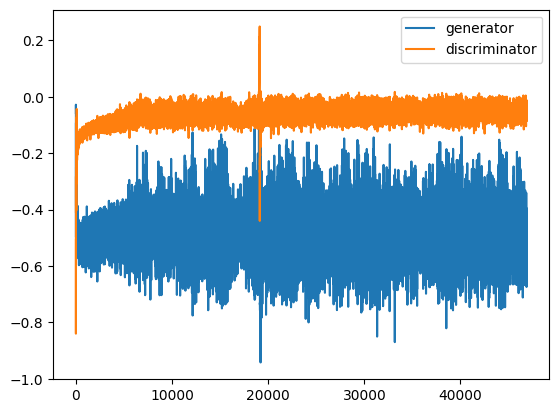

In [61]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
train_wgan_noise(discriminator, generator, data=data, epochs=100, log_every=20)

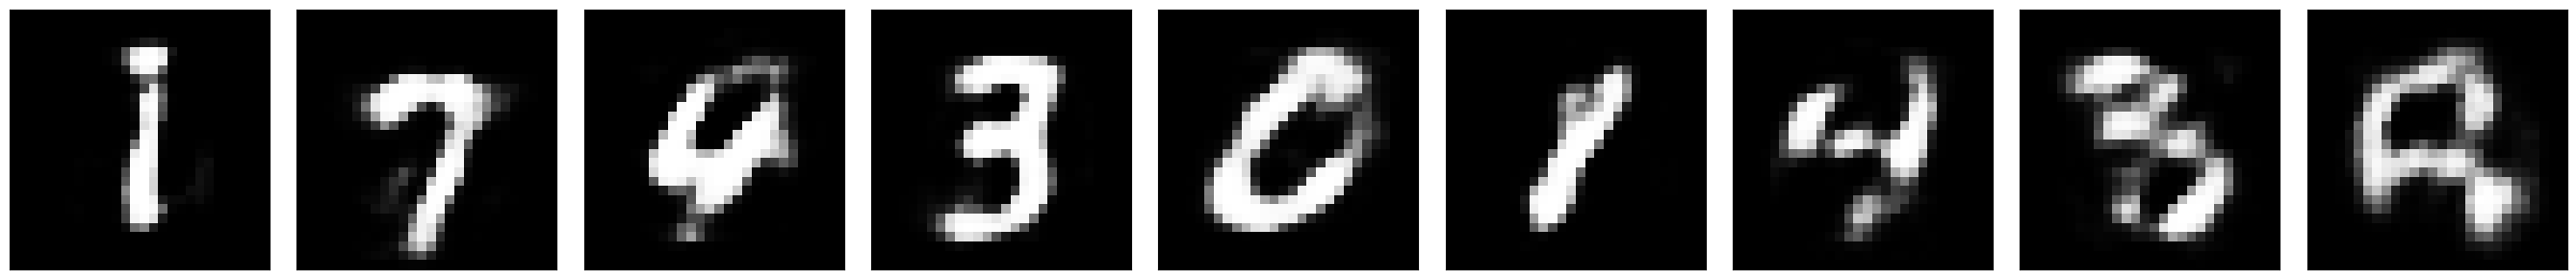

In [65]:
imgs = gen_images(generator, n=9)
plot(imgs)